In [1]:
# Load data from the Streaking Preprocessing .h5 file
# Last ran 07/16/2025

In [2]:
import os
import sys
sys.path.append('/sdf/data/lcls/ds/ued_testfac/scratch/python_packages')
import time
import numpy as np
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import configparser
import argparse
import scipy.ndimage.measurements as smt

from scipy.ndimage import gaussian_filter as gf
from scipy.optimize import curve_fit
from scipy.special import erf
from psana import DataSource
from numba import jit, njit
from ued_LCLSII_DAQ_utilities import *
from UEDePixTools import *
from tqdm import tqdm
from PIL import Image

In [3]:
exp = 'run'
run = 18

# Check main run file keys
print("Keys in main run file:")
with h5py.File(f"/sdf/group/rfar/timodo/ePixdata/{exp}_{run}.h5", 'r') as raw:
    for i_key in raw.keys():
        print(i_key)

print("\nKeys in part0 file:")
with h5py.File(f"/sdf/group/rfar/timodo/ePixdata/{exp}_{run}_part0.h5", 'r') as raw:
    for i_key in raw.keys():
        print(i_key)

runs = np.array([run])
print('Loading .h5 files for run(s):', runs)
tic = time.time()

main_data = {}
part0_data = {}

for run in runs:
    print(f'Loading run: {run}')
    main_path = f"/sdf/group/rfar/timodo/ePixdata/{exp}_{run}.h5"
    with h5py.File(main_path, 'r') as hf_main:
        print(f'  Loading main file: {exp}_{run}.h5')
        timestamp = np.argsort(np.array(hf_main.get('timestamp')))
        main_data[run] = {
            'shot_id': np.arange(0, len(timestamp))[timestamp],
            'scan_var_1': np.array(hf_main.get('step_value'))[timestamp].flatten(),
            'img_inte_1': np.array(hf_main.get('img_inte_1'))[timestamp],
            'img_inte_2': np.array(hf_main.get('img_inte_2'))[timestamp],
            'img_com_1': np.array(hf_main.get('img_com_1'))[timestamp],
            'img_com_2': np.array(hf_main.get('img_com_2'))[timestamp],
            'img_cut': np.array(hf_main.get('img_cut'))[timestamp]
        }
        print(f'    Main file shots: {len(main_data[run]["shot_id"])}')

    part0_path = f"/sdf/group/rfar/timodo/ePixdata/{exp}_{run}_part0.h5"
    with h5py.File(part0_path, 'r') as hf_part:
        print(f'  Loading part0 file: {exp}_{run}_part0.h5')
        timestamp = np.argsort(np.array(hf_part.get('timestamp')))
        part0_data[run] = {
            'shot_id': np.arange(0, len(timestamp))[timestamp],
            'scan_var_1': np.array(hf_part.get('step_value'))[timestamp].flatten(),
            'img_inte_1': np.array(hf_part.get('img_inte_1'))[timestamp],
            'img_inte_2': np.array(hf_part.get('img_inte_2'))[timestamp],
            'img_com_1': np.array(hf_part.get('img_com_1'))[timestamp],
            'img_com_2': np.array(hf_part.get('img_com_2'))[timestamp],
            'img_cut': np.array(hf_part.get('img_cut'))[timestamp]
        }
        print(f'    Part0 file shots: {len(part0_data[run]["shot_id"])}')

toc = time.time()
print(f'Load time: {np.round(toc-tic)} seconds')

Keys in main run file:
img_com_1
img_com_2
img_cut
img_inte_1
img_inte_2
step_value
timestamp

Keys in part0 file:
img_com_1
img_com_2
img_cut
img_inte_1
img_inte_2
step_value
timestamp
Loading .h5 files for run(s): [18]
Loading run: 18
  Loading main file: run_18.h5
    Main file shots: 10000
  Loading part0 file: run_18_part0.h5
    Part0 file shots: 10000
Load time: 3.0 seconds


In [4]:
for run in runs:
    # Main file summary
    delayss_main = np.unique(main_data[run]['scan_var_1'])
    print(f'Run {run} main file: {delayss_main.shape[0]} PV steps, {len(main_data[run]["shot_id"])} shots')
    print(f'  Image cut shape: {main_data[run]["img_cut"].shape}')

    # Part0 file summary
    delayss_part = np.unique(part0_data[run]['scan_var_1'])
    print(f'Run {run} part0 file: {delayss_part.shape[0]} PV steps, {len(part0_data[run]["shot_id"])} shots')
    print(f'  Image cut shape: {part0_data[run]["img_cut"].shape}')

Run 18 main file: 1 PV steps, 10000 shots
  Image cut shape: (10000, 65, 28)
Run 18 part0 file: 1 PV steps, 10000 shots
  Image cut shape: (10000, 65, 28)


In [5]:
# For single run (adapt if running multiple)
run = runs[0]

img_cut_main = main_data[run]['img_cut']
img_inte_2_main = main_data[run]['img_inte_2']
img_com_2_main = main_data[run]['img_com_2']
scan_var_1_main = main_data[run]['scan_var_1']

img_cut_part = part0_data[run]['img_cut']
img_inte_2_part = part0_data[run]['img_inte_2']
img_com_2_part = part0_data[run]['img_com_2']
scan_var_1_part = part0_data[run]['scan_var_1']

delayss_main = np.unique(scan_var_1_main)
delayss_part = np.unique(scan_var_1_part)

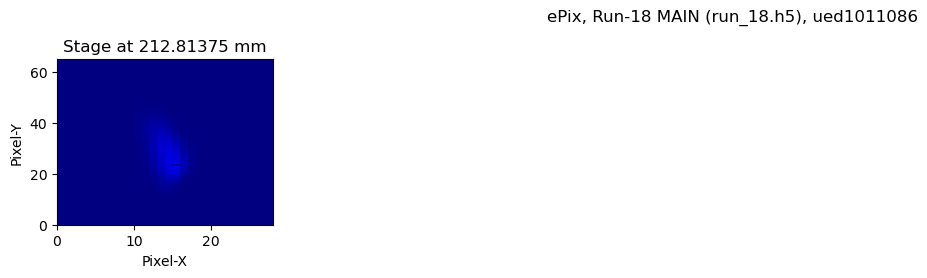

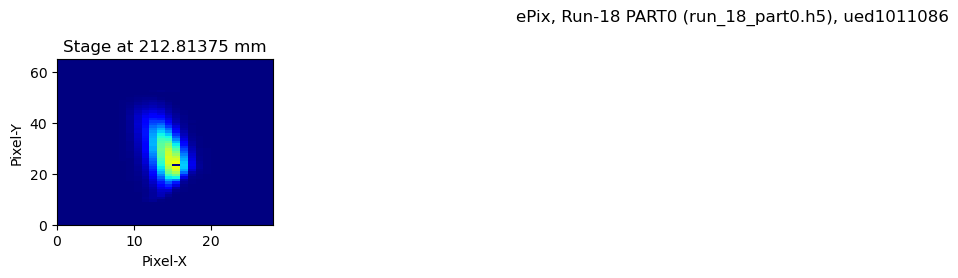

In [6]:
# MAIN run: only track available delays
img_runs_ave_main = []
delayss_main_available = []
for i_delay, delay in enumerate(delayss_main):
    flt_step = (scan_var_1_main == delay) & (img_com_2_main > 0) & (img_com_2_main < 60)
    if np.any(flt_step):
        img_runs_ave_main.append(img_cut_main[flt_step].mean(axis=0))
        delayss_main_available.append(delay)
img_runs_ave_main = np.array(img_runs_ave_main)

plt.figure(figsize=(15, 10))
plt.suptitle(f'ePix, Run-{run} MAIN (run_18.h5), ued1011086', y=0.98)
i_subplot = 1
for i_delay, delay in enumerate(delayss_main_available):
    if i_delay % 5 == 0:
        plt.subplot(4, 6, i_subplot)
        plt.pcolormesh(img_runs_ave_main[i_delay], cmap='jet')
        plt.clim([0, 70000])
        plt.xlabel('Pixel-X')
        plt.ylabel('Pixel-Y')
        plt.title(f'Stage at {delay} mm')
        i_subplot += 1

plt.tight_layout(pad=2.0, h_pad=2.5, w_pad=1.5)
plt.subplots_adjust(top=0.93)
plt.show()

# PART0 run (repeat the same approach)
img_runs_ave_part = []
delayss_part_available = []
for i_delay, delay in enumerate(delayss_part):
    flt_step = (scan_var_1_part == delay) & (img_com_2_part > 0) & (img_com_2_part < 60)
    if np.any(flt_step):
        img_runs_ave_part.append(img_cut_part[flt_step].mean(axis=0))
        delayss_part_available.append(delay)
img_runs_ave_part = np.array(img_runs_ave_part)

plt.figure(figsize=(15, 10))
plt.suptitle(f'ePix, Run-{run} PART0 (run_18_part0.h5), ued1011086', y=0.98)
i_subplot = 1
for i_delay, delay in enumerate(delayss_part_available):
    if i_delay % 5 == 0:
        plt.subplot(4, 6, i_subplot)
        plt.pcolormesh(img_runs_ave_part[i_delay], cmap='jet')
        plt.clim([0, 10000])
        plt.xlabel('Pixel-X')
        plt.ylabel('Pixel-Y')
        plt.title(f'Stage at {delay} mm')
        i_subplot += 1

plt.tight_layout(pad=2.0, h_pad=2.5, w_pad=1.5)
plt.subplots_adjust(top=0.93)
plt.show()

In [7]:
def compute_sumX_sumY(img_cut, scan_var_1, img_com_2, delays):
    """
    Returns dicts:
      sumX_dict[delay]: (n_images, N_pixels_X)
      sumY_dict[delay]: (n_images, N_pixels_Y)
    """
    sumX_dict = {}
    sumY_dict = {}
    for delay in delays:
        flt_step = (scan_var_1 == delay) & (img_com_2 > 0) & (img_com_2 < 60)
        images = img_cut[flt_step]
        if images.shape[0] == 0:
            continue
        sumX = images.sum(axis=1)  # sum over rows (Y) -> [n_images, N_pixels_X]
        sumY = images.sum(axis=2)  # sum over cols (X) -> [n_images, N_pixels_Y]
        sumX_dict[delay] = sumX
        sumY_dict[delay] = sumY
    return sumX_dict, sumY_dict

sumX_dict_main, sumY_dict_main = compute_sumX_sumY(
    img_cut_main, scan_var_1_main, img_com_2_main, delayss_main)

sumX_dict_part, sumY_dict_part = compute_sumX_sumY(
    img_cut_part, scan_var_1_part, img_com_2_part, delayss_part)

In [8]:
# Example: for a single delay value
example_delay = list(sumX_dict_main.keys())[0]
sumX_main = sumX_dict_main[example_delay]
sumY_main = sumY_dict_main[example_delay]
print("sumX_main shape:", sumX_main.shape)  # (n_images, N_pixels_X)
print("sumY_main shape:", sumY_main.shape)  # (n_images, N_pixels_Y)

sumX_main shape: (9999, 28)
sumY_main shape: (9999, 65)


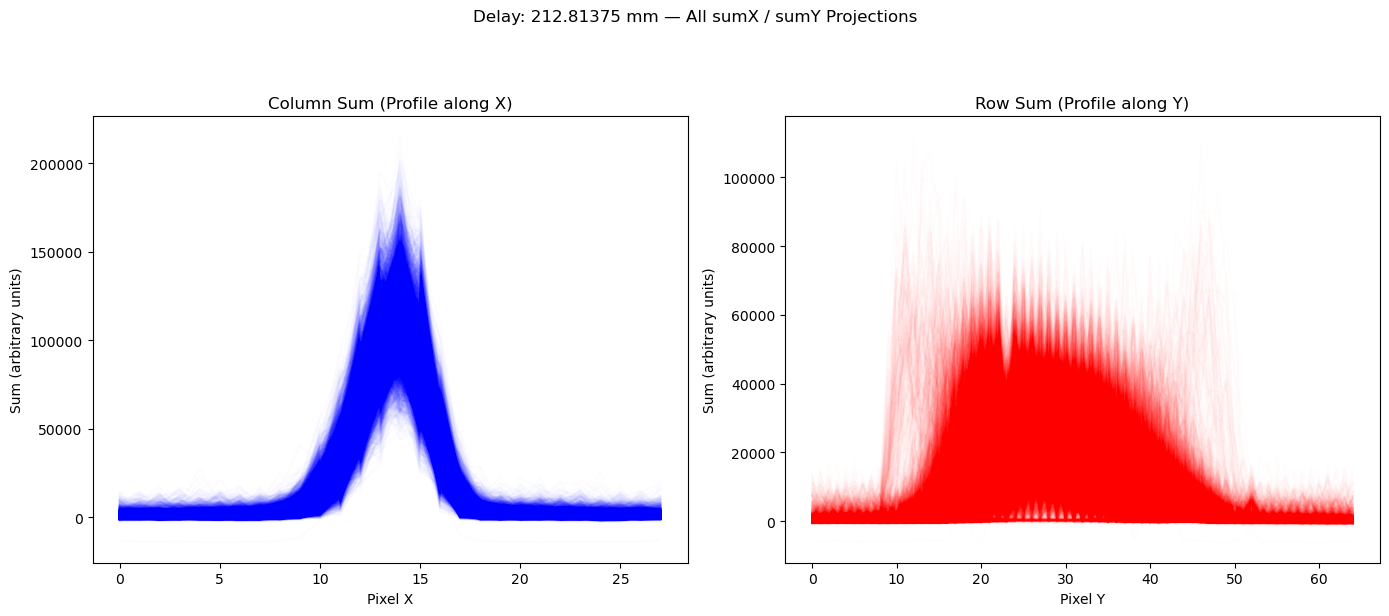

In [9]:
def plot_all_sumX_sumY(sumX_dict, sumY_dict, delays, max_plots=3):
    """
    Plots all sumX and sumY for each delay (for first max_plots delays).
    """
    for i, delay in enumerate(delays[:max_plots]):
        if delay not in sumX_dict or delay not in sumY_dict:
            continue
        sumX = sumX_dict[delay]
        sumY = sumY_dict[delay]

        plt.figure(figsize=(14, 6))
        plt.suptitle(f"Delay: {delay} mm — All sumX / sumY Projections", y=1.02)
        plt.subplot(1, 2, 1)
        for curve in sumX:
            plt.plot(curve, color='blue', alpha=0.01)
            plt.title("Column Sum (Profile along X)")
            plt.xlabel("Pixel X")
            plt.ylabel("Sum (arbitrary units)")

        plt.subplot(1, 2, 2)
        for curve in sumY:
            plt.plot(curve, color='red', alpha=0.01)
            plt.title("Row Sum (Profile along Y)")
            plt.xlabel("Pixel Y")
            plt.ylabel("Sum (arbitrary units)")

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

# To use:
plot_all_sumX_sumY(sumX_dict_main, sumY_dict_main, list(sumX_dict_main.keys()), max_plots=2)

In [10]:
save_dir = "/sdf/group/rfar/timodo/ePix_Runs_Pixel_Sum_Data"
run_number = 18
os.makedirs(save_dir, exist_ok=True)

# Calculate projection for all images in the run
sumX = img_cut_main.sum(axis=1)  # shape: (n_images, X)
sumY = img_cut_main.sum(axis=2)  # shape: (n_images, Y)
x_pixels = np.arange(img_cut_main.shape[2])
y_pixels = np.arange(img_cut_main.shape[1])

np.savez(
    f"{save_dir}/run_{run_number}_all_sumX.npz",
    x_pixels=x_pixels,
    sumX=sumX
)
np.savez(
    f"{save_dir}/run_{run_number}_all_sumY.npz",
    y_pixels=y_pixels,
    sumY=sumY
)

print(f"[INFO] Saved all per-image sumX and sumY arrays for run {run_number} in {save_dir}")

[INFO] Saved all per-image sumX and sumY arrays for run 18 in /sdf/group/rfar/timodo/ePix_Runs_Pixel_Sum_Data
